<a href="https://colab.research.google.com/github/Balaaabduljalil/NaijaSenti/blob/main/Naija_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Data Exploratory Data Analysis

In this notebook, we are going to explore the Covid_19 data to uncover useful insights. The data contains sentiments of Nigerians about the Covid Vaccination. At the end of this analysis, the following questions are expected to be answred:

1. What is the overall opinion of Nigerians about the vaccine?
2. What are the Positive Words in Peoples'  Opinion?
3. What are the Negative Words in Peoples'  Opinion?

4. What are the most common words that are withing the positive sentiment?

5. What are the most common words that are withing the negative sentiment?

6. What are the most common words that are withing the neutral sentiment?

7. What are the main topics in the positive sentiment

8. What are the main topics in the negative sentiment

9. Is there difference between the topics in the negative and positive sentiments?

## Mounting the Drive and Importing the Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import numpy as np


## Reading the sentiment Data

Here, we read the data :



In [ ]:
df = pd.read_csv('/content/drive/My Drive/final.csv')

In [ ]:
df = df.rename(columns={'text': 'Text', 'final': 'Sentiment'})


## Exploring the Data

Let's look at the first few rows:

In [ ]:
df.head()


,Text,Sentiment
0,its covid it self not the vaccine sorry about ...,0
1,na covid ooooo rearing its head pls but d adve...,0
2,good morning aunty yeni in lagos people are be...,2
3,for where where the vaccine dey,0
4,waec on which date did buhari received his cov...,0


### What is Total Number of Negaitve, Positive, and Neutral sentiments?
Knowing the total number of each sentiment class determines ether the vaccine is accepted or rejected in Nigeria

In [ ]:
df['final'].value_counts()


0    2155
2    1084
1     747
Name: final, dtype: int64

There are:

1.   2155  neutral sentiments;
2.   1084 positive sentiments; and
3.   747 negetive sentiments.

we can use seaborn barplot to visualize this:

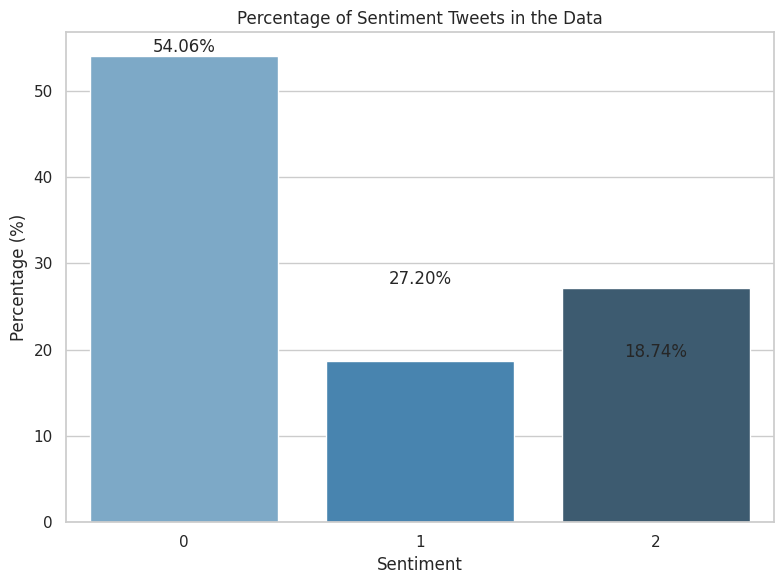

In [ ]:


# Calculate the value counts and percentages
value_counts = df['Sentiment'].value_counts()
percentage = (value_counts / len(df)) * 100
percentage_df = pd.DataFrame({'Sentiment': percentage.index, 'Percentage': percentage.values})

sns.set(style="whitegrid")  # Set the style of the plot (optional)

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6) )
sns.barplot(data=percentage_df, x='Sentiment', y='Percentage', palette='Blues_d')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Sentiment Tweets in the Data')

# Add percentage values on top of the bars
for index, row in percentage_df.iterrows():
    plt.text(index, row['Percentage'], f'{row["Percentage"]:.2f}%', ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

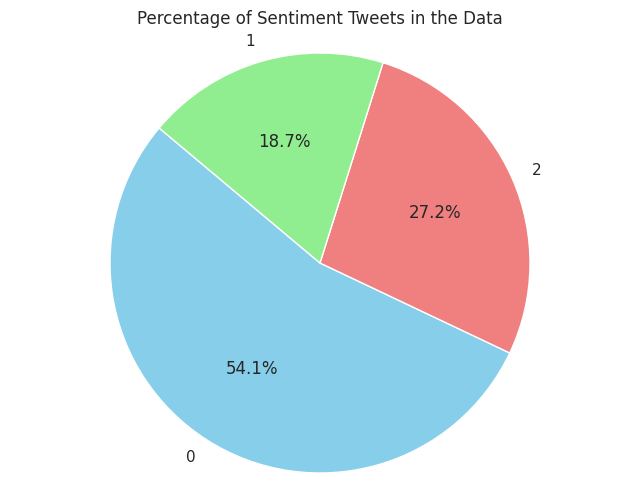

In [ ]:
# Calculate the value counts and percentages
value_counts = df['Sentiment'].value_counts()
percentage = (value_counts / len(df)) * 100

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(percentage, labels=percentage.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen'])

# Add a title
plt.title('Percentage of Sentiment Tweets in the Data')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

From the figures , it can be deduced that majority of Nigerians are neutral about covid-19 vaccination; those that accept the vacine are relatively more than the hesitant ones.

### What are the Positive Words in Peoples'  Opinion?
We can visualize the main positive words used by Nigerians to express their acceptance of the vaccine using word cloud library:

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


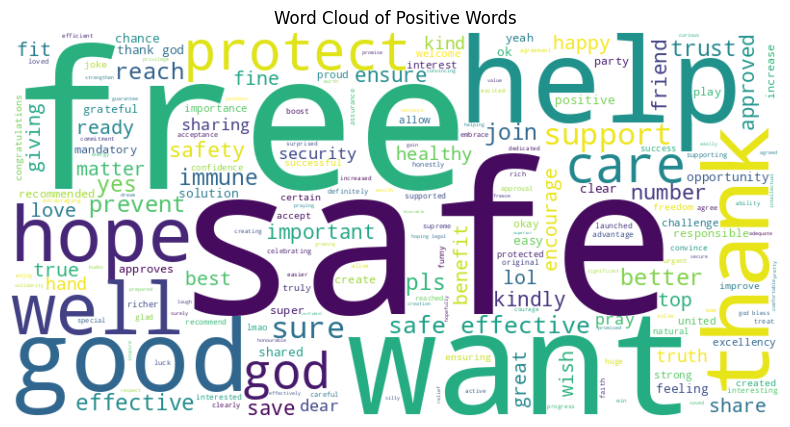

In [ ]:
# Download NLTK resources (if not already downloaded)
nltk.download('vader_lexicon')


# Function to filter positive words using sentiment analysis
def filter_positive_words(text):
    sia = SentimentIntensityAnalyzer()
    words = text.split()
    lis =['please']

    positive_words = [word for word in words  if word not in lis and sia.polarity_scores(word)['compound'] > 0]
    return ' '.join(positive_words)

# Apply the filter_positive_words function to the 'text' column
df['positive_text'] = df['Text'].apply(filter_positive_words)

# Combine all the filtered positive words into a single string
positive_text = ' '.join(df['positive_text'])

# Create a WordCloud object for the positive words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Words')
plt.show()

### What are the Negative Words in Peoples'  Opinion?
We can visualize the the freuently used negative words by Nigerians to express their disagreement with the safety of the vaccine using word cloud library also:

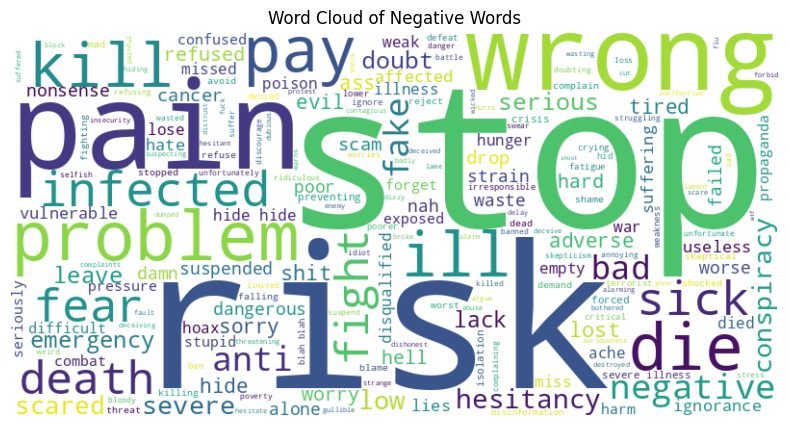

In [ ]:
# Function to filter negative words using sentiment analysis
def filter_negative_words(text):
    sia = SentimentIntensityAnalyzer()
    words = text.split()
    negative_words = [word for word in words if sia.polarity_scores(word)['compound'] < 0]
    return ' '.join(negative_words)

# Apply the filter_negative_words function to the 'text' column
df['negative_text'] = df['text'].apply(filter_negative_words)

# Combine all the filtered negative words into a single string
negative_text = ' '.join(df['negative_text'])

# Create a WordCloud object for the negative words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Words')
plt.show()

### Keyword Extraction for Postive Negative and Neutral sentiments
Here, we are trying to identify the most common words making a tweet to be either positive, negative, or neutral. To achieve this, we do the following:

1.  Extract each of the three sentiment cateogry into a separate column in the data frame.
2.   Remove stopwords and tokenize
3.   Use barplots and wordcloud to visualize the most commonnest words



In [ ]:
pos_tweet = df[df['Sentiment'] == 2] ['Text']
neg_tweet = df[df['Sentiment'] == 1] ['Text']
neut_tweet = df[df['Sentiment'] == 0]['Text']

In [ ]:
pos_tweet

Let's now remove the stop words; to do this, we need a text cleaning package called neattext:

In [ ]:
!pip install neattext

After installing the text cleaning package, import the needed functions:

In [ ]:
import neattext.functions as ntx


In [ ]:
pos_tweet_list = pos_tweet.apply(ntx.remove_stopwords).tolist()
neg_tweet_list = neg_tweet.apply(ntx.remove_stopwords).tolist()
neut_tweet_list = neut_tweet.apply(ntx.remove_stopwords).tolist()

Tokenize each line in to tokens:

In [ ]:
pos_tokens = [token for line in pos_tweet_list for token in line.split()]
neg_tokens = [token for line in neg_tweet_list for token in line.split()]
neut_tokens = [token for line in neut_tweet_list for token in line.split()]

Get most common words:

In [ ]:
from collections import Counter

In [ ]:
def get_most_common(doc, num = 30):
  tokens = Counter(doc)
  common_tokens = dict(tokens.most_common(num))
  return common_tokens


In [ ]:
most_common_pos = get_most_common(pos_tokens)
most_common_neg = get_most_common(neg_tokens)
most_common_neut = get_most_common(neut_tokens)

In [ ]:
most_common_pos

we can now plot the common words with seaborn barplot after converting the dictionary to data frame:

In [ ]:
neg_df = pd.DataFrame(most_common_neg.items(), columns=['word', 'score'])

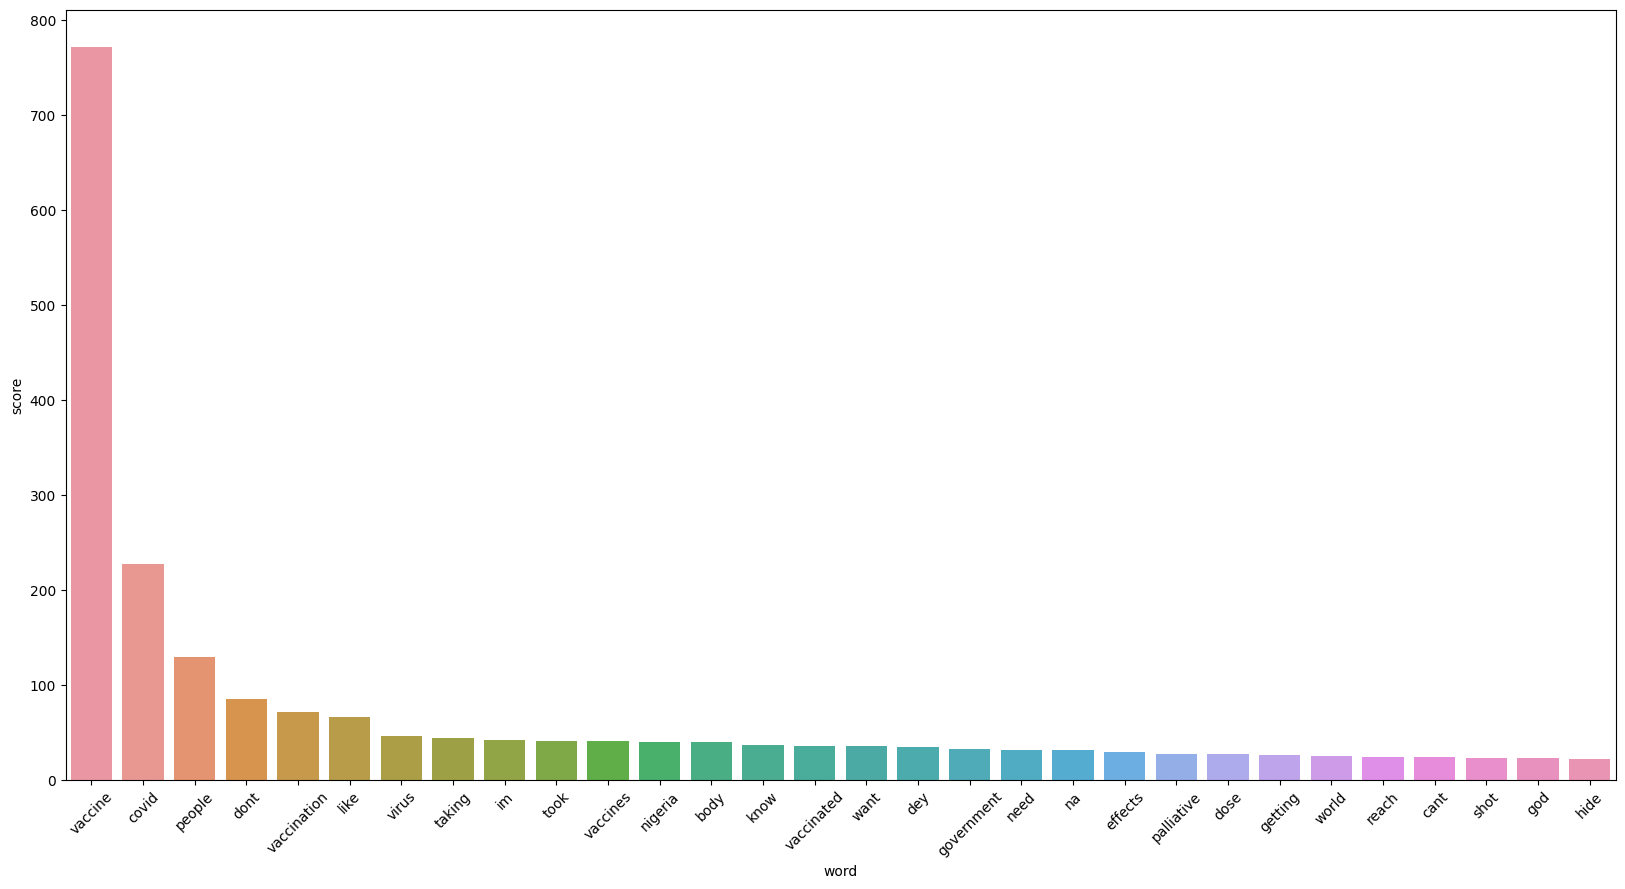

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='word', y='score', data=neg_df)
plt.xticks(rotation = 45)
plt.show()

These are the most common words withing the negative sentiment. From this we can undertand that people of this tweets don't like the covid vaccination because of perceived negative effect.

let check the most common words withing positive and neutral sentiment:

In [ ]:
pos_df = pd.DataFrame(most_common_pos.items(), columns=['word', 'score'])

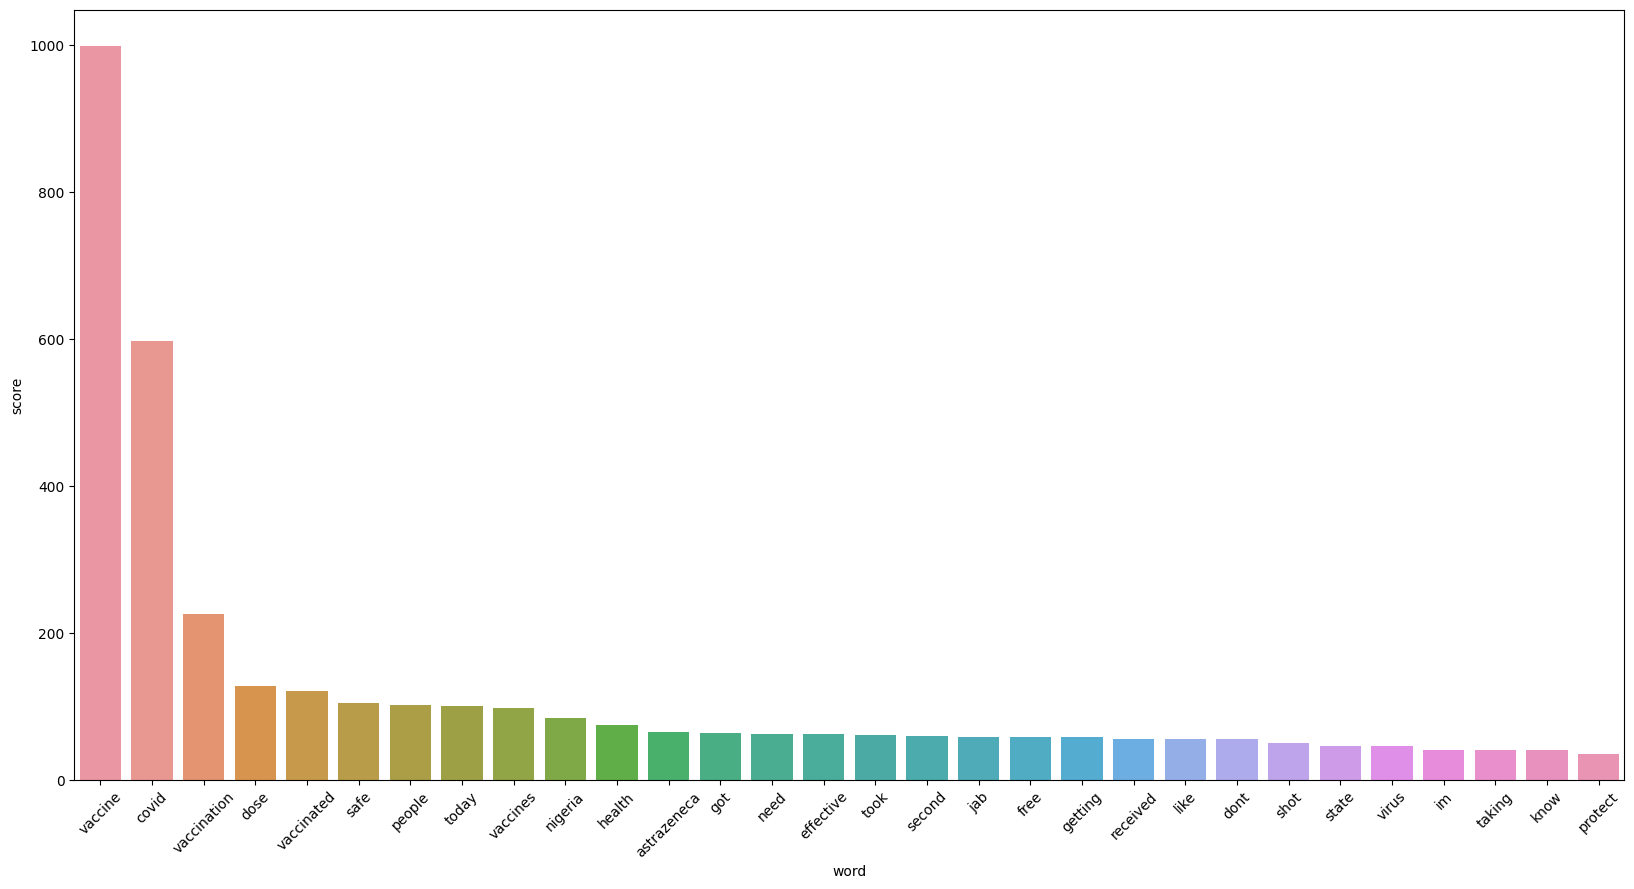

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='word', y='score', data=pos_df)
plt.xticks(rotation = 45)
plt.show()

**From** this we can deduce that people of this tweets believed that the vaccine is safe and it protect one's health.

In [ ]:
neut_df = pd.DataFrame(most_common_neut.items(), columns=['word', 'score'])

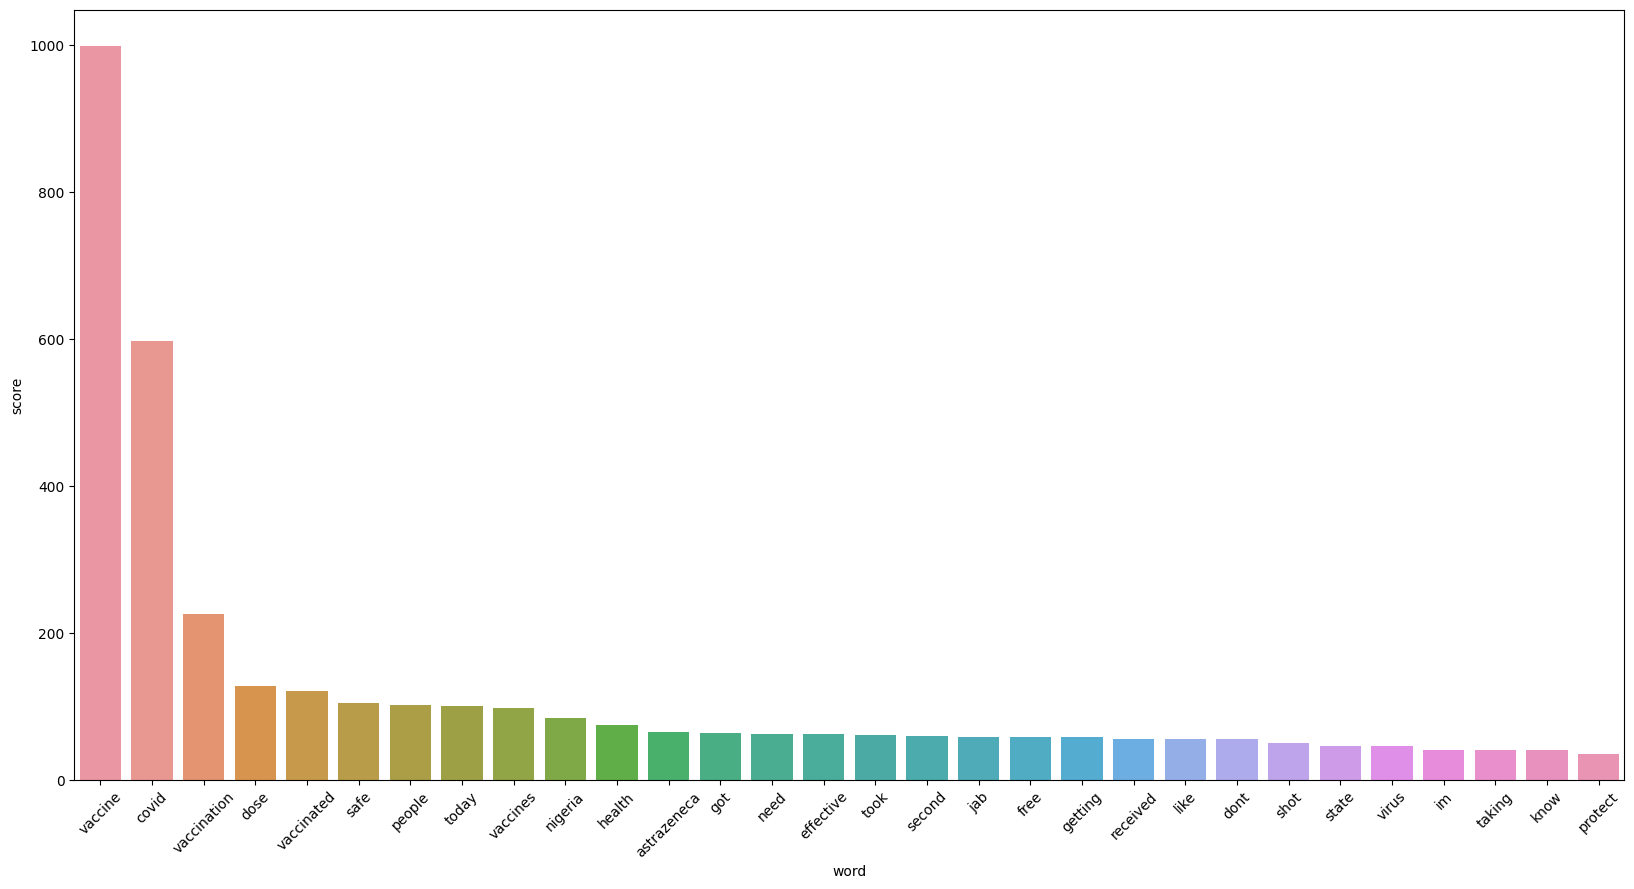

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='word', y='score', data=pos_df)
plt.xticks(rotation = 45)
plt.show()

Looking at the most frequent words here, we know that these people's opinion  is neutral, as the tweet is neither poitive nor negative.

since we have gotten the most commonest words from each class, we can do a word cloud for them:

In [ ]:
from wordcloud import WordCloud

Let's create a function that does that:

In [ ]:
def plot_wordcloud(doc):
    # Create a WordCloud object and generate the word cloud
    mywordcloud = WordCloud().generate(doc)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10,5))
    plt.imshow(mywordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
#Need to convert our token back to list
neg_doc = "  ".join(neg_tokens)
pos_doc = "  ".join(pos_tokens)
neut_doc = "  ".join(neut_tokens)

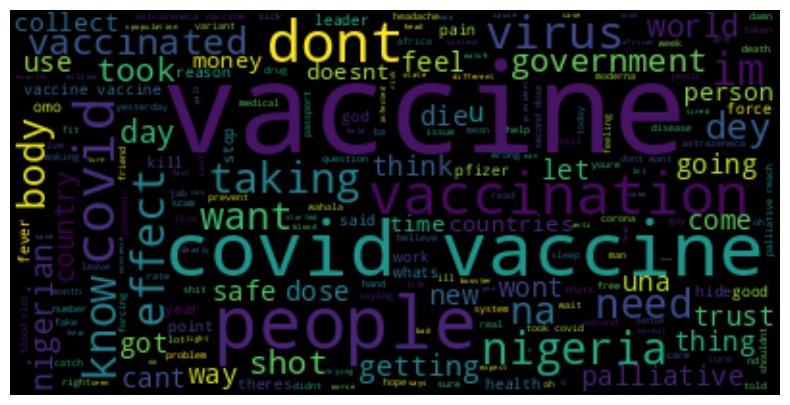

In [ ]:
plot_wordcloud(neg_doc)


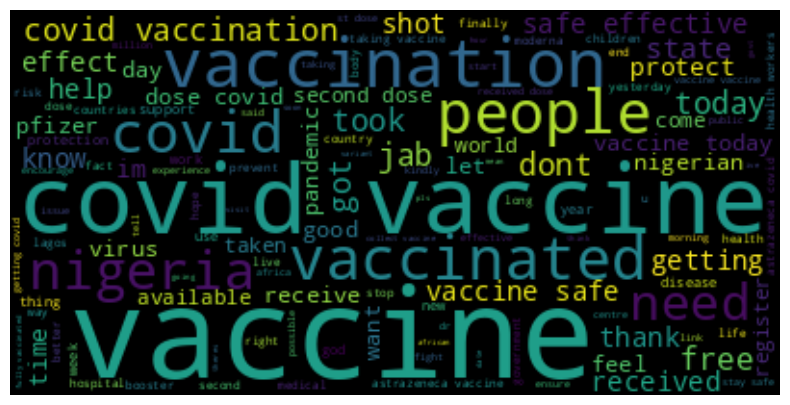

In [ ]:
plot_wordcloud(pos_doc)


In [ ]:
plot_wordcloud(neut_doc)

NameError: ignored

## Topic Modelling

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [ ]:
pos_tokens = [token for line in pos_tweet_list for token in line.split()]
neg_tokens = [token for line in neg_tweet_list for token in line.split()]
neut_tokens = [token for line in neut_tweet_list for token in line.split()]



## what are top 5 topics in the Positive sentiment?

In [ ]:
import pandas as pd
from gensim import corpora, models
from wordcloud import WordCloud
import matplotlib.pyplot as plt



df = pd.DataFrame(pos_tweet)


# Tokenize the text
tokenized_text = df['Text'].apply(lambda x: x.split())

# Create a dictionary and convert the tokens into a bag-of-words representation
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Train an LDA model
lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)


topics = lda_model.print_topics(num_words=5)
topic_df = pd.DataFrame(topics, columns=['Topic', 'Words'])
print(topic_df)


   Topic                                              Words
0      0  0.022*"of" + 0.022*"vaccine" + 0.020*"and" + 0...
1      1  0.045*"the" + 0.039*"vaccine" + 0.025*"to" + 0...
2      2  0.051*"the" + 0.032*"to" + 0.031*"vaccine" + 0...


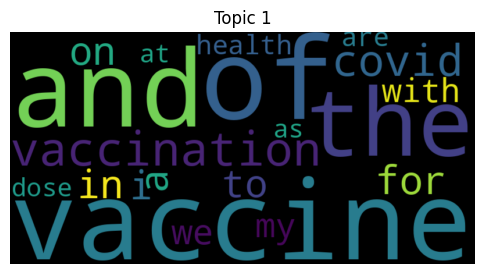

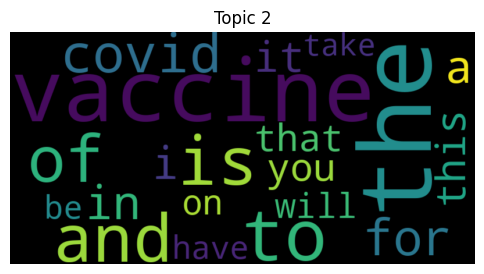

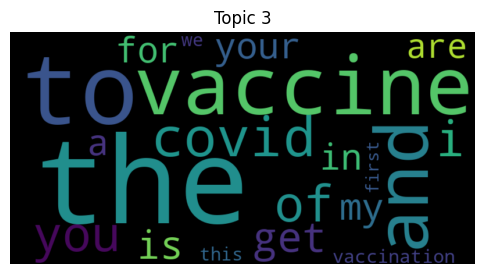

In [ ]:
# Create a word cloud for each topic
for i in range(lda_model.num_topics):
    plt.figure(figsize=(6, 4))
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(dict(lda_model.show_topic(i, topn=20)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.show()

### what are top 5 topics in the Negative sentiment?

In [ ]:
df = pd.DataFrame(neg_tweet)


# Tokenize the text
tokenized_text = df['Text'].apply(lambda x: x.split())

# Create a dictionary and convert the tokens into a bag-of-words representation
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Train an LDA model
lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)


topics = lda_model.print_topics(num_words=5)
topic_df = pd.DataFrame(topics, columns=['Topic', 'Words'])
print(topic_df)

   Topic                                              Words
0      0  0.042*"vaccine" + 0.026*"the" + 0.024*"i" + 0....
1      1  0.048*"the" + 0.039*"vaccine" + 0.020*"and" + ...
2      2  0.041*"the" + 0.034*"vaccine" + 0.027*"to" + 0...


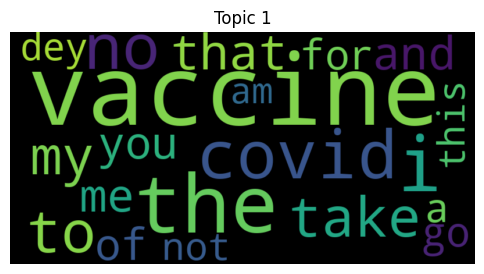

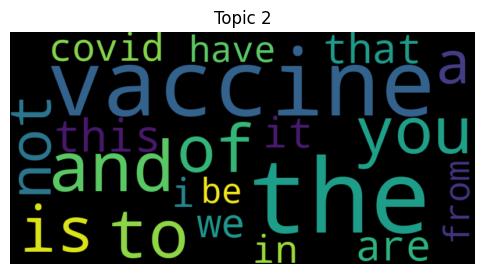

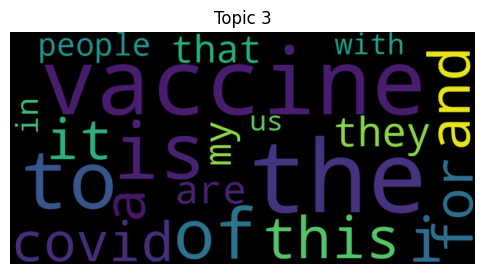

In [ ]:
# Create a word cloud for each topic
for i in range(lda_model.num_topics):
    plt.figure(figsize=(6, 4))
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(dict(lda_model.show_topic(i, topn=20)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.show()

## Relevant Hashtags

In [ ]:
df = pd.read_csv('/content/drive/My Drive/vaccine_v1_raw.csv')
df = pd.DataFrame({'Tweet_Text':df['sourcetweet_text'].dropna()})

df.head()

,Tweet_Text
13,I took the Astrazeneca vaccine yesterday amids...
15,"#COVID19Lagos Update As at 15th of March, 2021..."
18,Both of them were vaccinated no??? Why are the...
52,@chuks_nadia Do a brief research about covid v...
99,Take whatever vaccine is made available to you...


In [ ]:
def extract_hashtags(tweet):
    hashtags = re.findall(r'#\w+', tweet)
    return hashtags

hashtags_list = df['Tweet_Text'].apply(extract_hashtags)
all_hashtags = [tag for sublist in hashtags_list for tag in sublist]

# Count the occurrences of each hashtag
hashtags_count = Counter(all_hashtags)

# Convert the count into a DataFrame
common_hashtags_df = pd.DataFrame(hashtags_count.most_common(30), columns=['Hashtag', 'Count'])

# Display the common hashtags
print(common_hashtags_df)


                   Hashtag  Count
0                 #COVID19     38
1     #YesToCOVID19Vaccine     18
2              #vaccinated      6
3                   #COVAX      5
4                 #Nigeria      4
5            #vanguardnews      3
6                   #COVID      3
7    #COVID19VaccineIsSafe      3
8                #Covid_19      3
9            #VaccinEquity      2
10                      #1      2
11    #CITADagainstCovid19      2
12                    #WHO      2
13                #covid19      2
14                   #PRAC      2
15     #AstraZenecaVaccine      2
16          #VaccineEquity      2
17           #YesToCOVID19      2
18               #BREAKING      2
19              #WearAMask      2
20         #COVID19vaccine      2
21                  #Ghana      2
22   #SayYesToCovidVaccine      2
23                   #Kano      2
24        #IHateInjections      2
25    #YesToCovid19Vaccine      2
26  #WorldImmunizationWeek      2
27           #COVID19Lagos      1
28  #covid_19V

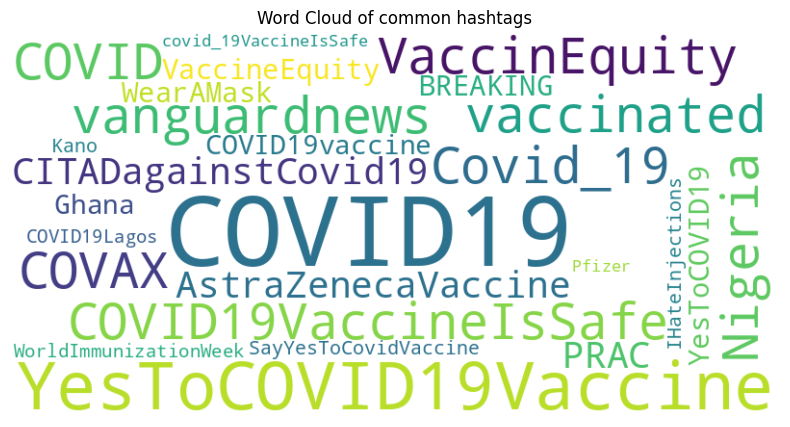

In [ ]:
# Create a WordCloud object for the common hashtags
text = ' '.join(common_hashtags_df["Hashtag"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of common hashtags')
plt.show()

## Sentiment Analysis  with Support Vector Machine (SVM)
1.   The code splits the data into training and testing sets,
2.   vectorizes the text data using TF-IDF,
3.   calculates class weights using the class_weight parameter to handle class
     imbalance,
4.   builds an SVM model using the RBF kernel
5.   It then prints the classification report, which includes metrics like
     precision, recall, F1-score, and support for each class

Note: Remember to fine-tune the hyperparameters and preprocessing steps to obtain the best model performance.

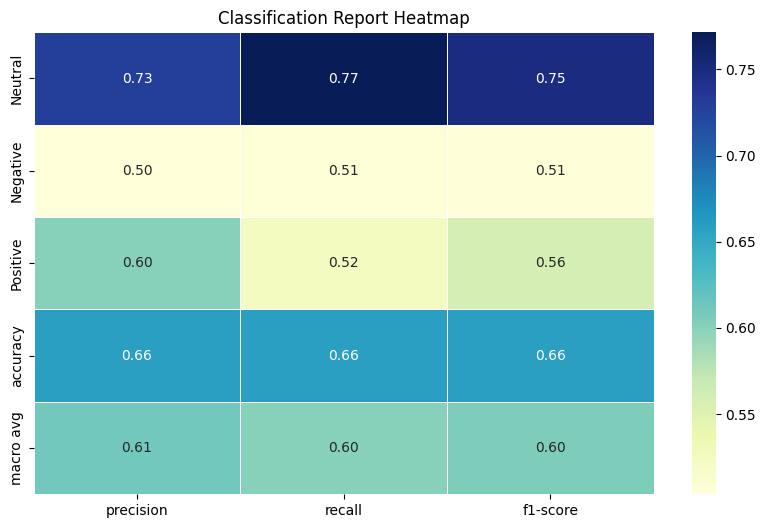

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


# Preprocessing: Assuming you have a 'text' column for text data and a 'label' column for sentiment labels
X = df['Text']
y = df['Sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1, 2], y=y_train)

# Build and train the SVM model with the best hyperparameters (adjust these as needed)
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale', class_weight=dict(enumerate(class_weights)))
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test_tfidf)

# Print the classification report
target_names = ['Neutral', 'Negative', 'Positive']
classification_rep = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Convert the classification report to a DataFrame
classification_df = pd.DataFrame(classification_rep).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(classification_df.iloc[:-1, :3], annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title('Classification Report Heatmap')
plt.show()




## Sentiment Analysis  with Logistic Regression



1.   It preprocesses the text data using TF-IDF vectorization and removes
     English stopwords.
2.   Class weights are calculated to handle class imbalance.
3.   GridSearchCV is used to search for the best hyperparameter (C) using  
     cross-validation.
4.   The best model is selected based on the grid search results.
5.   The classification report is printed with meaningful labels ('Neutral',
     'Negative', 'Positive').


Note: we can further fine-tune hyperparameters or adjust the TF-IDF settings




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import class_weight


# Preprocessing: Assuming you have a 'text' column for text data and a 'label' column for sentiment labels
X = df['Text']
y = df['Sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # You can adjust max_features and stopwords
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1, 2], y=y_train)

# Hyperparameter Tuning using GridSearchCV
pa weram_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  # Regularization parameter
}

logistic_regression_model = LogisticRegression(class_weight=dict(enumerate(class_weights)))
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters
best_logistic_regression_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_logistic_regression_model.predict(X_test_tfidf)

# Print the classification report
target_names = ['Neutral', 'Negative', 'Positive']
classification_rep = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Create a DataFrame from the classification report
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Visualize the classification report as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ConfusionMatrixDisplay.from_estimator(best_logistic_regression_model, X_test_tfidf, y_test, ax=ax, cmap='viridis')
heatmap.ax_.set_title('Classification Report Heatmap')
plt.show()

# Print the detailed classification report in tabular form
print(classification_rep_df)

SyntaxError: ignored